In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.fftpack
from scipy import signal
import scipy.io.wavfile
import copy
from scipy import optimize
import cv2
%matplotlib inline
from scipy import ndimage, misc
from scipy.signal import butter, lfilter
from matplotlib.pyplot import loglog
import mmcv, cv2
from scipy.fft import fft, ifft
import math
from scipy import signal


In [63]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def rgb_mean(ROI,number_of_skin_pixels):
    r = np.sum(ROI[:, :, 2]) / number_of_skin_pixels
    g = np.sum(ROI[:, :, 1]) / number_of_skin_pixels
    b = np.sum(ROI[:, :, 0]) / number_of_skin_pixels

    return r,g,b

def sig_detrend(sig, method, time):
    if method=="constant":
         return signal.detrend(sig,type="constant")
    elif method=="linear":
         return signal.detrend(sig,type="linear")
    elif method=="polymonial":
        lin = lambda x, a, b : a * x + b 
        coeff, _ = optimize.curve_fit(lin,time, sig)
        sig= sig-( coeff[0] * time + coeff[1])
        return sig
    else:
        return sig

def bandpass(sig, method,lowcut,highcut, Fs, order):
    if method=="butter":
        return butter_bandpass_filter(sig, lowcut, highcut, Fs, order=order)   
    
    else:
        return sig
    
def preprocess_signal(sig,detrend_method,time,bandpass_method,lowcut,highcut, Fs, order):
    detrended_signal=sig_detrend(sig,detrend_method,time)
    bandpassed_signal=bandpass(detrended_signal, bandpass_method,lowcut,highcut, Fs, order)
    
    return bandpassed_signal

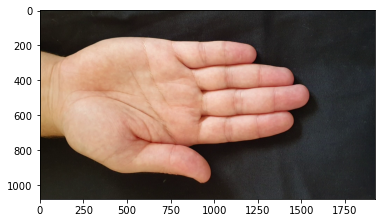

In [64]:
video = mmcv.VideoReader('palm.mp4')
raw_frames = [cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) for frame in video]
raw_frames=raw_frames[:250]
plt.imshow(raw_frames[3])

In [65]:
N=len(raw_frames)
T=1/video.fps
Fs=video.fps
time=np.arange(0,N)/Fs
fouer_x=np.linspace(0.0, 1.0/(2.0*T), N//2)

detrend_method="constant"
bandpass_method="butter"
lowcut = 0.5
highcut=6
order=5
blur=False
blur_kernel=(150,150)
heart_beat=1

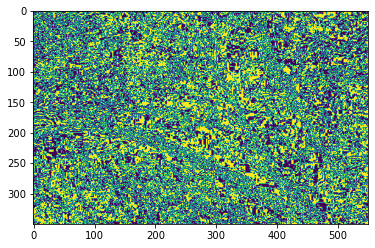

In [77]:
mean_rgb = np.empty((0, 3))
ROI_frames=[]
for frame in raw_frames:
    ROI=frame[300:650,250:800]
    b, g, r = cv2.split(ROI)

    height, width, channels = ROI.shape
    img_size = (height, width)
    bit_size = img_size + (8,)
    g_bits = np.unpackbits(g).reshape(bit_size)
    ROI=g_bits[:,:,5:8]
    ROI_frames.append(ROI)
    r,g,b=rgb_mean(ROI, ROI.shape[0]*ROI.shape[1])
    mean_rgb = np.append(mean_rgb, np.array([[r, g, b]]), axis=0)

green=[frame[:,:,1] for frame in ROI_frames]

if blur:
    frames=blur_frames(green,blur_kernel)
else:
    frames=green
    
plt.imshow(frames[3])

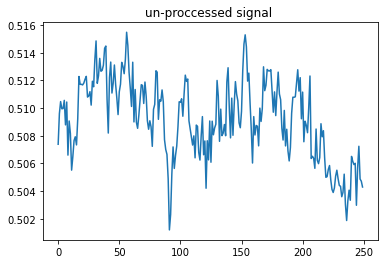

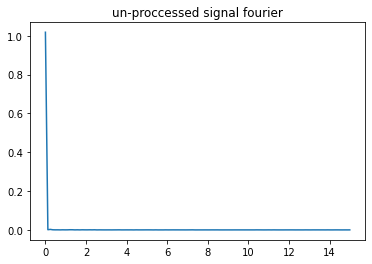

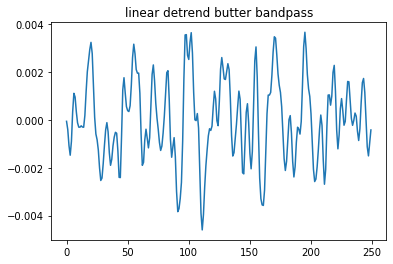

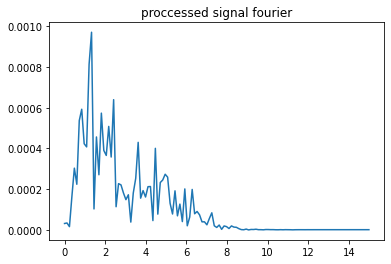

In [78]:
show_for="ROI"
example_pixel=[300,50]
detrend_method="linear"
bandpass_method="butter"
lowcut = 0.5
highcut=6
order=5

if show_for=="pixel":
    sig=get_signal_from_frames(example_pixel,frames)
else:
    sig=mean_rgb[:,1]

plt.plot(sig)
plt.title('un-proccessed signal ')

plt.show()

f=fft(sig)
plt.plot(fouer_x, 2.0/N * np.abs(f[0:N//2]))
plt.title('un-proccessed signal fourier')
plt.xlim()
plt.show()

proc_sig=preprocess_signal(sig,detrend_method,time,bandpass_method,lowcut,highcut, Fs, order )
plt.plot(proc_sig)
plt.title(f'{detrend_method} detrend {bandpass_method} bandpass' )
plt.show()

f=fft(proc_sig)
plt.plot(fouer_x, 2.0/N * np.abs(f[0:N//2]))
plt.title('proccessed signal fourier')
plt.xlim()
plt.show()

In [36]:
np.packbits(g).shape

(259200,)

In [33]:
img=raw_frames[3]
b, g, r = cv2.split(img)

height, width, channels = img.shape
img_size = (height, width)
bit_size = img_size + (8,)

In [37]:
1080*1920

2073600

In [19]:
g_bits

array([[0, 0, 1, ..., 0, 1, 1],
       [0, 0, 1, ..., 1, 0, 1],
       [0, 0, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

In [20]:
1920*8

15360